In [50]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import precision_recall_curve


# model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
# optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)

scaler = MinMaxScaler()
numerical_features = df.select_dtypes(include=[np.number]).columns.tolist()
df[numerical_features] = scaler.fit_transform(df[numerical_features])

class_weight = {0: 1.2, 1: 0.8}  # Adjust based on error analysis



# Load the dataset (Ensure the file is in the correct directory)
df = pd.read_csv('animal_conflict_updated_dataset.csv')

# Handle missing values and ensure 'Date' column exists
if 'Date' in df.columns:
    df['Date'] = pd.to_datetime(df['Date'], errors='coerce')  # Convert Date column
    df = df.dropna(subset=['Date'])  # Remove rows with invalid Date values
    df['Day'] = df['Date'].dt.day
    df['Month'] = df['Date'].dt.month  # Ensure Month is numeric
    df['Year'] = df['Date'].dt.year
    df.drop(columns=['Date'], inplace=True)  # Drop original Date column

# Convert 'Month' if it's in text format
if 'Month' in df.columns and df['Month'].dtype == 'object':
    months_dict = {
        'January': 1, 'February': 2, 'March': 3, 'April': 4, 'May': 5, 'June': 6,
        'July': 7, 'August': 8, 'September': 9, 'October': 10, 'November': 11, 'December': 12
    }
    df['Month'] = df['Month'].map(months_dict)

# Encode categorical columns
label_encoders = {}
categorical_columns = ['Species', 'Conflict_Type', 'Location', 'Crop_Stage']
for col in categorical_columns:
    if col in df.columns:  # Check if column exists
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col].astype(str))
        label_encoders[col] = le  # Store encoder for later use

        
        
if 'Conflict_Occurrence' in df.columns:
    df['Conflict_Occurrence'] = df['Conflict_Occurrence'].astype(int)
else:
    raise ValueError("Column 'Conflict_Occurrence' is missing in the dataset.")

# Normalize existing numerical features
existing_numerical_features = [col for col in numerical_features if col in df.columns]
if existing_numerical_features:  # Ensure there are features to normalize
    df[existing_numerical_features] = scaler.fit_transform(df[existing_numerical_features])
else:
    print("Warning: No numerical features found for normalization.")

    
# Function to create sequences for LSTM
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data.iloc[i:i+seq_length].drop('Conflict_Occurrence', axis=1).values)
        y.append(data.iloc[i+seq_length]['Conflict_Occurrence'])
    return np.array(X), np.array(y)

seq_length = 7  # Use past 7 days to predict the next day
X, y = create_sequences(df, seq_length)

# Split into training and testing sets (80% train, 20% test)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Check array shapes before model training
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

# model = Sequential([
#     LSTM(128, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
#     Dropout(0.3),
#     LSTM(64, return_sequences=False),
#     Dropout(0.3),
#     Dense(32, activation='relu'),
#     Dense(1, activation='sigmoid')
# ])
from tensorflow.keras.regularizers import l2
LSTM(256, return_sequences=True, kernel_regularizer=l2(0.01))



model = Sequential([
    LSTM(256, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    BatchNormalization(),
    Dropout(0.4),
    LSTM(128, return_sequences=False),
    BatchNormalization(),
    Dropout(0.4),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])

# model = keras.Sequential([
#     layers.Input(shape=(7, 17)),  # Assuming 7 time steps, 17 features
#     layers.LSTM(64, return_sequences=True, kernel_regularizer=keras.regularizers.l2(0.01)),
#     layers.Dropout(0.2),
#     layers.LSTM(32, return_sequences=False, kernel_regularizer=keras.regularizers.l2(0.01)),
#     layers.Dropout(0.2),
#     layers.Dense(16, activation='relu', kernel_regularizer=keras.regularizers.l2(0.01)),
#     layers.Dense(1, activation='sigmoid')
# ])

# # Compile model with focal loss
# model.compile(
#     optimizer=keras.optimizers.Adam(learning_rate=1e-4),
#     loss=BinaryFocalCrossentropy(gamma=2),
#     metrics=['accuracy']
# )

# # Train model
# history = model.fit(
#     X_train, y_train,
#     validation_data=(X_test, y_test),
#     epochs=50,
#     batch_size=32,
#     class_weight=class_weight_dict,
#     verbose=1
# )


model.compile(optimizer=Adam(learning_rate=0.0005), loss='binary_crossentropy', metrics=['accuracy'])




#training model
# from tensorflow.keras.callbacks import LearningRateScheduler

# def lr_scheduler(epoch, lr):
#     if epoch < 10:
#         return lr
#     else:
#         return lr * tf.math.exp(-0.1)

# model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
# history = model.fit(X_train, y_train, epochs=50, batch_size=16, validation_data=(X_test, y_test), callbacks=[LearningRateScheduler(lr_scheduler)])

# history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(
    class_weight="balanced", 
    classes=np.unique(y_train), 
    y=y_train
)

class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}


history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), class_weight=class_weight_dict)



# Save the trained model
model.save('animal_intrusion_lstm_model.keras')
print(df['Conflict_Occurrence'].value_counts())
# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Predict on test data

from sklearn.metrics import precision_recall_curve

# Predict probabilities
y_probs = model.predict(X_test)


# from sklearn.metrics import roc_curve
# fpr, tpr, thresholds = roc_curve(y_test, y_probs)
# optimal_idx = np.argmax(tpr - fpr)
# optimal_threshold = thresholds[optimal_idx]

# # Find optimal threshold
# precision, recall, thresholds = precision_recall_curve(y_test, y_probs)
# f1_scores = 2 * (precision * recall) / (precision + recall)
# optimal_threshold = thresholds[np.argmax(f1_scores)]

# # Apply optimal threshold
# y_pred = (y_probs > optimal_threshold).astype(int)

from sklearn.metrics import roc_curve

y_probs = model.predict(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]

y_pred_optimal = (y_probs > optimal_threshold).astype(int)


# Confusion Matrix
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Classification Report
from sklearn.metrics import classification_report
print("Classification Report:")
print(classification_report(y_test, y_pred))

X_train shape: (794, 7, 17)
X_test shape: (199, 7, 17)
y_train shape: (794,)
y_test shape: (199,)


C:\Users\sunil\jupiter_tensorflow\tensorflow_personal\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 16s 140ms/step - accuracy: 0.4807 - loss: 0.8374 - val_accuracy: 0.4975 - val_loss: 0.6933
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step - accuracy: 0.5694 - loss: 0.7195 - val_accuracy: 0.4472 - val_loss: 0.7011
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - accuracy: 0.5605 - loss: 0.7157 - val_accuracy: 0.4774 - val_loss: 0.6976
Epoch 4/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step - accuracy: 0.5452 - loss: 0.7200 - val_accuracy: 0.4623 - val_loss: 0.7019
Epoch 5/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.5659 - loss: 0.7114 - val_accuracy: 0.4372 - val_loss: 0.7075
Epoch 6/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.5857 - loss: 0.6827 - val_accuracy: 0.4673 - val_loss: 0.6946
Epoch 7/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.5712 - loss: 0.7171 - val_accuracy: 0.4422 - val_loss: 0.7140
Epoch 8/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.5872 - loss: 0.6869 - val_accuracy: 0.5427 -

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.4892 - loss: 0.9688
Test Loss: 0.9899171590805054
Test Accuracy: 0.5226130485534668
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 109ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Confusion Matrix:
[[45 44]
 [50 60]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.47      0.51      0.49        89
         1.0       0.58      0.55      0.56       110

    accuracy                           0.53       199
   macro avg       0.53      0.53      0.52       199
weighted avg       0.53      0.53      0.53       199



7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


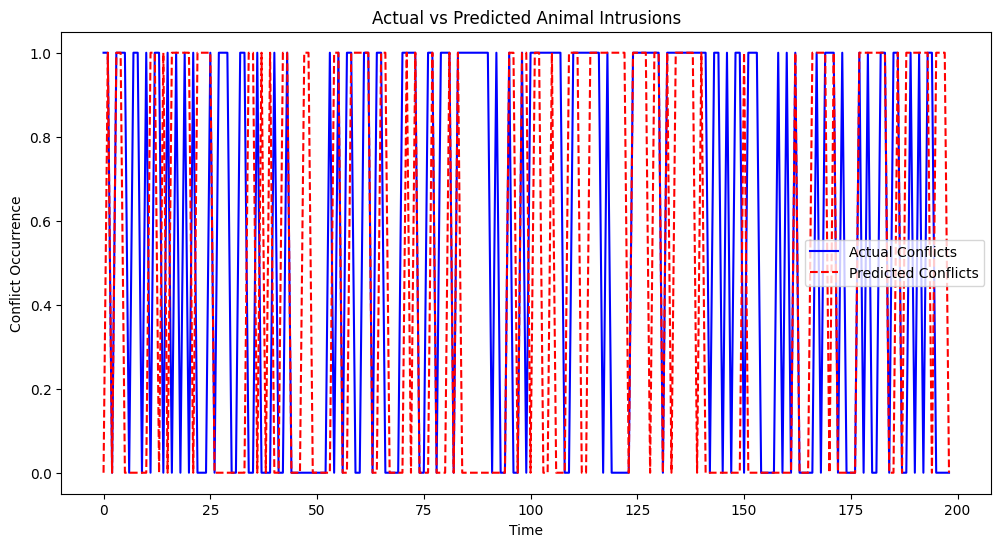

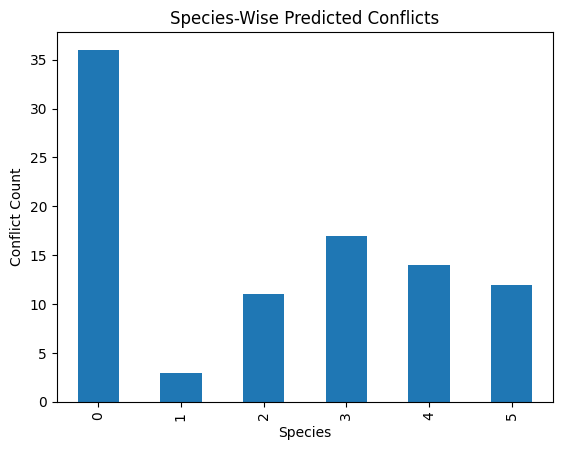

In [51]:
import matplotlib.pyplot as plt

# Predict on test data
y_pred = (model.predict(X_test) > 0.5).astype(int)

# Plot actual vs predicted conflicts
plt.figure(figsize=(12, 6))
plt.plot(y_test, label='Actual Conflicts', color='blue')
plt.plot(y_pred, label='Predicted Conflicts', color='red', linestyle='dashed')
plt.title('Actual vs Predicted Animal Intrusions')
plt.xlabel('Time')
plt.ylabel('Conflict Occurrence')
plt.legend()
plt.show()

# Analyze species-wise trends
df_test = df.iloc[train_size+seq_length:].copy()
df_test['Predicted_Conflict'] = y_pred

species_conflicts = df_test.groupby('Species')['Predicted_Conflict'].sum()
species_conflicts.plot(kind='bar', title='Species-Wise Predicted Conflicts')
plt.xlabel('Species')
plt.ylabel('Conflict Count')
plt.show()

In [52]:
import requests

def fetch_weather_data(lat, lon, api_key):
    url = f"http://api.openweathermap.org/geo/1.0/weather?lat={12.7369}&lon={77.8326}&appid={1a65eeab7da1f99096861c44a3150bba}&units=metric"
    response = requests.get(url)
    data = response.json()
    return {
        'Temperature': data['main']['temp'],
        'Humidity': data['main']['humidity'],
        'Wind_Speed': data['wind']['speed'],
        'Rainfall': data.get('rain', {}).get('1h', 0)  # Rainfall in the last hour
    }

# Example: Fetch weather data for Hosur
api_key = 'your_openweathermap_api_key'
hosur_lat, hosur_lon = 12.7369, 77.8326
weather_data = fetch_weather_data(hosur_lat, hosur_lon, api_key)
print(weather_data)

SyntaxError: invalid decimal literal (986828090.py, line 4)